## Here we look into how it is possible for the model to produce good segmentations while our motion tracking is simply put too small to produce such an effect

### First, let's compare the model's `ED` and `ES` point sets with the ground truth's `ED` and `ES`

In [1]:
model_name = "Original_Pretrained_R2plus1DMotionSegNet.pth"

# model_name = "dropout_v2_0_25_R2plus1DMotionSegNet.pth"
# model_name = "dropout_v3_0_10_R2plus1DMotionSegNet.pth"

In [2]:
import os
os.chdir("../..")
print(os.getcwd())

%config Completer.use_jedi = False

import SimpleITK as itk
from LabelFusion.wrapper import fuse_images

import echonet
from echonet.datasets import Echo

import torch.nn.functional as F
from torchvision.models.video import r2plus1d_18
from torch.utils.data import Dataset, DataLoader, Subset
from multiprocessing import cpu_count

from src.utils.torch_utils import TransformDataset, torch_collate
from src.utils.echo_utils import get2dPucks
from src.utils.camus_validate import cleanupSegmentation
from src.transform_utils import generate_2dmotion_field
from src.visualization_utils import categorical_dice
from src.loss_functions import huber_loss, convert_to_1hot, convert_to_1hot_tensor
from src.echonet_dataset import EDESpairs, EchoNetDynamicDataset

from src.model.R2plus1D_18_MotionNet import R2plus1D_18_MotionNet

# v2 dropout (in place before motion heads, forgot to define in forward pass function, but still saw diff, weird.)
from src.model.dropout_v2_0_00_R2plus1D_18_MotionNet import dropout_v2_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_10_R2plus1D_18_MotionNet import dropout_v2_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_25_R2plus1D_18_MotionNet import dropout_v2_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_50_R2plus1D_18_MotionNet import dropout_v2_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v2_0_75_R2plus1D_18_MotionNet import dropout_v2_0_75_R2plus1D_18_MotionNet
# v3 dropout (one dropout layer defined in forward pass func, this should've been the correct way to do it.)
from src.model.dropout_v3_0_00_R2plus1D_18_MotionNet import dropout_v3_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_10_R2plus1D_18_MotionNet import dropout_v3_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_25_R2plus1D_18_MotionNet import dropout_v3_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_50_R2plus1D_18_MotionNet import dropout_v3_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v3_0_75_R2plus1D_18_MotionNet import dropout_v3_0_75_R2plus1D_18_MotionNet
# v4 dropout (4 dropout layers in different places in the forward func, I'm going to guess more "generalizable")
from src.model.dropout_v4_0_00_R2plus1D_18_MotionNet import dropout_v4_0_00_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_10_R2plus1D_18_MotionNet import dropout_v4_0_10_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_25_R2plus1D_18_MotionNet import dropout_v4_0_25_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_50_R2plus1D_18_MotionNet import dropout_v4_0_50_R2plus1D_18_MotionNet
from src.model.dropout_v4_0_75_R2plus1D_18_MotionNet import dropout_v4_0_75_R2plus1D_18_MotionNet

# for finding lv seg borders
import cv2 as cv

# for storing vector snapshots
import copy

# from src.visualization_utils import categorical_dice

import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import random
import pickle
import time

tic, toc = (time.time, time.time)


device = 'cuda' if torch.cuda.is_available() else 'cpu'
device


batch_size = 4
num_workers = max(4, cpu_count()//2)


def worker_init_fn_valid(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)
    

def worker_init_fn(worker_id):
    # See here: https://pytorch.org/docs/stable/notes/randomness.html#dataloader
    # and the original post of the problem: https://github.com/pytorch/pytorch/issues/5059#issuecomment-817373837
    worker_seed = torch.initial_seed() % 2 ** 32
    print(f'worker_seed: {worker_seed}')
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    

def permuter(list1, list2):
    for i1 in list1:
        for i2 in list2:
            yield (i1, i2)
            

param_trainLoader = {'collate_fn': torch_collate,
                     'batch_size': batch_size,
                     'num_workers': max(4, cpu_count()//2),
                     'worker_init_fn': worker_init_fn}

param_testLoader = {'collate_fn': torch_collate,
                    'batch_size': batch_size,
                    'shuffle': False,
                    'num_workers': max(4, cpu_count()//2),
                    'worker_init_fn': worker_init_fn}

paramLoader = {'train': param_trainLoader,
               'valid': param_testLoader,
               'test':  param_testLoader}


with open("fold_indexes/stanford_valid_sampled_indices", "rb") as infile:
    valid_mask = pickle.load(infile)
infile.close()

# full_dataset = EchoNetDynamicDataset(split='val', clip_length="full", subset_indices=valid_mask, period=1)
test_dataset = EchoNetDynamicDataset(split='test', clip_length="full", raise_for_es_ed=False, period=1)
# random_test_dataset = EchoNetDynamicDataset(split='test', clip_length=32, raise_for_es_ed=True, period=1)

/home/wang/workspace/JupyterNoteBooksAll/fully-automated-multi-heartbeat-echocardiography-video-segmentation-and-motion-tracking


100%|██████████| 16/16 [00:01<00:00, 13.62it/s]


In [3]:
model_save_path = f"save_models/{model_name}"
    
if model_name == 'Original_Pretrained_R2plus1DMotionSegNet.pth':
    model_template_obj = R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_00_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_00_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_10_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_10_R2plus1D_18_MotionNet()
elif model_name == 'dropout_v2_0_25_R2plus1DMotionSegNet.pth':
    model_template_obj = dropout_v2_0_25_R2plus1D_18_MotionNet()


elif model_name == "dropout_v3_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v3_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v3_0_25_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_00_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_00_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_10_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_10_R2plus1D_18_MotionNet()
elif model_name == "dropout_v4_0_25_R2plus1DMotionSegNet.pth":
    model_template_obj = dropout_v4_0_25_R2plus1D_18_MotionNet()


model = torch.nn.DataParallel(model_template_obj)

model.to("cuda")
torch.cuda.empty_cache()
model.load_state_dict(torch.load(model_save_path)["model"])
print(f'{model_name} has {sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters.')
model.eval();

Original_Pretrained_R2plus1DMotionSegNet.pth has 31575731 parameters.


In [4]:
from src.strain import *

In [5]:
%matplotlib widget

functions, functions, functions...

In [6]:
def vis_single_point_set_from_vectors(ps_vectors):
    ''' ps_vectors - (N, ) np array storing vectors with format (x, y, delta_x, delta_y) '''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    x = []
    y = []
    for v in ps_vectors:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax.scatter(x, y, marker='.', color='b')
    ax.invert_yaxis()

In [7]:
def vis_two_vector_point_sets_one_figure(ps1, ps2):
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    x = []
    y = []
    for v in ps1:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax.scatter(x, y, marker='.', color='b', zorder=2)
    x = []
    y = []
    for v in ps2:
        x.append(v.tail_x)
        y.append(v.tail_y)
    ax.scatter(x, y, marker='.', color='k', zorder=1)
    ax.invert_yaxis()
    ax.set_title('ps1 Blue | ps2 Black')

In [8]:
def vis_single_point_set(ps):
    ''' ps - (N, 2) stored in (x,y)'''
    f, ax = plt.subplots(1, 1, figsize=(4, 5))
    ax.scatter(ps[:, 0], ps[:, 1], marker='.', color='b')
    ax.invert_yaxis()

In [9]:
def image_to_whole_point_set(I):
    '''
    I - (112, 112) whole image segmentation
    points - (N, 2) stored in x, y
    '''
    I = give_boundary_no_basal_plane(I)
    points = []
    for i in range(I.shape[0]):
        for j in range(I.shape[1]):
            if I[i][j] == 1:
                points.append(np.array([j, i]))
    return np.array(points)

In [10]:
def convert_point_set_ij_into_xy(ps_ij):
    ''' 
    converts a point set of shape (M, 2) of points in the (i,j) format into 
    point set of shape (M, 2) of points in the (x,y) format where
    x = j
    y = i
    
    input: ps_ij - (M , 2)
    output: ps_xy - (M, 2)
        
    '''
    ps_xy = []
    for point in ps_ij:
        ps_xy.append(np.array([point[1], point[0]]))
    return np.array(ps_xy)

In [11]:
def convert_point_set_xy_into_vectors(ps_xy):
    '''
    converts a single point set passed in of shape (M, 2) into a np array of vector adts of shape (M, ) 
    vectors will have x,y with zero magnitudes representing deltas
    
    assumes the Vector ADT class definition is accessible in global scope
 
    input: ps_xy - (M, 2)
    output: ps_vectors - (M, )
    '''
    ps_vectors = []
    for point in ps_xy:
        ps_vectors.append(Vector(point[0], point[1], 0, 0))
    return np.array(ps_vectors)

In [12]:
def warp_one_vector_forward_once(v, frame, motion):
    '''
    input: 
        v - vector to warp
            should have base values: (x_i, y_j, 0, 0)
        frame - frame integer index
        motion - motion object of shape (4, 32, 112, 112)
    output:
        v_new - vector after warped from given frame
            base values: (x_i+1, y_j+1, 0, 0)
            
    frame given determines what motion tracking information to use
    as the frame integer value will be used to index motion
    '''
    # get surrounding vectors forming the unit square
    inted_i, inted_j = int(v.tail_y), int(v.tail_x)
    surr_vec_tails = [ [inted_i, inted_j],
                       [inted_i, inted_j+1],
                       [inted_i+1, inted_j],
                       [inted_i+1, inted_j+1] ]
    
    surround_vectors = []

    for _ in surr_vec_tails:
        i,j = _[0], _[1]
        x = j
        y = i

        forward_x = motion[0][frame][i][j]
        forward_y = motion[1][frame][i][j]

        surround_vectors.append(Vector(x, y, forward_x, forward_y))
        
    # convert magnitudes into polar, bilinearly interpolate new vector magnitude in polar
    # to the input vector v's tail_x, tail_y, convert back into 
    # cartesian, apply the warp, clear out conversion value holders
    v_new = vector_bilinear_interpolation(vectors=surround_vectors, new_vector=v)
    v_new.update_mag_xy_from_conversion()
    v_new.update_tails_from_mags()
    
    v_new.clear_conversion_mags_xy()
    v_new.clear_conversion_mags_rhotheta()
    v_new.clear_magnitudes()
    
    return v_new

In [13]:
def warp_one_vector_forward_delta_times(v, motion, delta):
    ''' 
    handles warping forward a single vector specifically delta times and returns the new vector 
    
    input:
        v - vector to warp
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    '''
    for i in range(delta):
        v = warp_one_vector_forward_once(v, i, motion)
    return v

In [14]:
def warp_one_point_set_forward_delta_times(ps_vectors, motion, delta):
    '''
    input:
        ps_vectors - (M, )
            input vectors of base values (x_i, y_i, 0, 0)
        motion - motion object of shape (4, 32, 112, 112)
        delta - integer telling us how many times to warp
    output:
        ps_vectors_new - (M, )
            new vectors of base values (x_i+delta, y_i+delta, 0, 0)
                if save_mag flag is False
    '''
    ps_vectors = copy.deepcopy(ps_vectors)
    
    ps_vectors_new = []
    for v in ps_vectors:
        ps_vectors_new.append(warp_one_vector_forward_delta_times(v, motion, delta))
    return np.array(ps_vectors_new)

In [15]:
N = 3
test_pat_index = 0

curr_clip_segmentations, curr_clip_motions, delta_ed_es, clip_index, ed_label, es_label = get_seg_and_warp_data(model = model,
                                                                                            test_dataset = test_dataset,
                                                                                            test_pat_index = test_pat_index)
    
ed_raw_seg_out = curr_clip_segmentations[:,0,...]
ed_one_hot_seg_out = one_hot(ed_raw_seg_out)

es_raw_seg_out = curr_clip_segmentations[:,delta_ed_es,...]
es_one_hot_seg_out = one_hot(es_raw_seg_out)

plot the whole point set
overlaying model's ED with label ED
same for ES

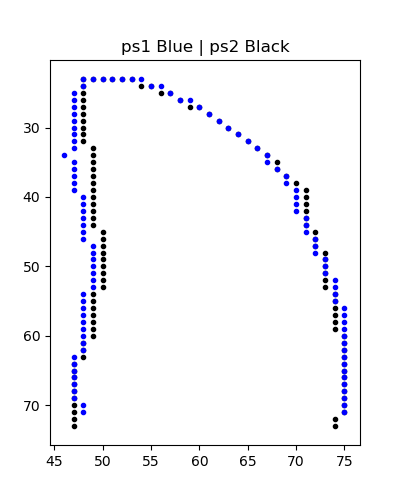

In [16]:
ed_model_ps = convert_point_set_xy_into_vectors(image_to_whole_point_set(ed_one_hot_seg_out))
ed_label_ps = convert_point_set_xy_into_vectors(image_to_whole_point_set(ed_label))

vis_two_vector_point_sets_one_figure(ed_model_ps, ed_label_ps)

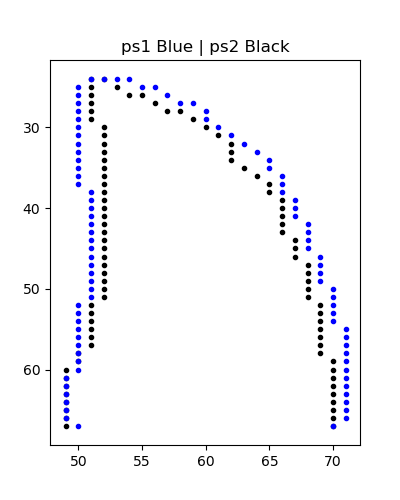

In [17]:
es_model_ps = convert_point_set_xy_into_vectors(image_to_whole_point_set(es_one_hot_seg_out))
es_label_ps = convert_point_set_xy_into_vectors(image_to_whole_point_set(es_label))

vis_two_vector_point_sets_one_figure(es_model_ps, es_label_ps)

## Ok, that looks reasonable, unlike my previous visualizations of warping `ED` from the model out into a fake `ES` using only the motion tracking information for the regional point sets, or even the entire point set.
## The warping for now only works when I do it the exact same way as defined in the functions using torch functional grid sample

It looks like this function generates a grid of (delta_x, delta_y)'s that is added to the starting grid of (x,y)'s.

In [18]:
def generate_2dmotion_field(x, offset):
    # Qin's code for joint_motion_seg learning works fine on our purpose too
    # Same idea https://discuss.pytorch.org/t/warp-video-frame-from-optical-flow/6013/5
    x_shape = x.size()
    grid_w, grid_h = torch.meshgrid([torch.linspace(-1, 1, x_shape[2]), torch.linspace(-1, 1, x_shape[3])])  # (h, w)
    grid_w = grid_w.cuda().float()
    grid_h = grid_h.cuda().float()

    grid_w = nn.Parameter(grid_w, requires_grad=False)
    grid_h = nn.Parameter(grid_h, requires_grad=False)

    offset_h, offset_w = torch.split(offset, 1, 1)
    offset_w = offset_w.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)
    offset_h = offset_h.contiguous().view(-1, int(x_shape[2]), int(x_shape[3]))  # (b*c, h, w)

    offset_w = grid_w + offset_w
    offset_h = grid_h + offset_h
    
    offsets = torch.stack((offset_h, offset_w), 3)

    return offsets

## This function looks like its a loss with the goal to minimize the magnitude of difference between the back to back vectors.
## Idea is that movement should be smooth, not jaggedy or abrupt, so it looks at the derivatives of the vectors ? 
## Minimize the difference in derivatives ? 

## Would this not have the side effect of minimizing the magnitude? I guess not, because the derivative is independent of that

In [19]:
def smoothness_loss(motion_output):
    r""" The smoothness loss computed using the displacement u (motion_field)
         motion_output: the output from the motion tracking head shape=N x C(2) x H x W """
    # Mean 
    dy = motion_output[:, 0, 1:, :-1] - motion_output[:, 0, :-1, :-1]
    dx = motion_output[:, 1, :-1, 1:] - motion_output[:, 1, :-1, :-1]
    #loss = dx.abs().mean() + dy.abs().mean()
    #loss = torch.mean(torch.sum(dx ** 2 + dy ** 2, dim=(1, 2)))
    loss = torch.mean(dx ** 2 + dy ** 2)
    
    return loss

## What is this?

In [20]:
def OTA_loss(source_image, motion_field, regulator_gamma=10):
    r""" The appearance level motion tracking loss
         source_image: The echo image sequence. 
         motion_field: The output from the motion tracking head shape=N x C (4) x D (10) x H x W
         regulator_gamma: A trade-off parameter for smoothness loss
    """
    corre_loss = 0
    smooth_loss = 0
    for index in range(source_image.shape[2] - 1):
        forward_motion = motion_field[:, :2, index,...]
        #backward_motion = motion_field[:, 2:, index,...]
        backward_motion = motion_field[:, 2:, index + 1,...]
        
        grid_forward = generate_2dmotion_field(source_image[:, :, index,...], forward_motion)
        grid_backward = generate_2dmotion_field(source_image[:, :, index + 1,...], backward_motion)
        
        pred_image_forward = F.grid_sample(source_image[:, :, index,...], grid_forward, align_corners=False, mode='bilinear', padding_mode='border')
        pred_image_backward = F.grid_sample(source_image[:, :, index + 1,...], grid_backward, align_corners=False, mode='bilinear', padding_mode='border')
        
        corre_loss += local_cross_correlation(source_image[:, :, index + 1,...], pred_image_forward, 4)
        corre_loss += local_cross_correlation(source_image[:, :, index,...], pred_image_backward, 4)
        
        smooth_loss += smoothness_loss(forward_motion)
        smooth_loss += smoothness_loss(backward_motion)
        #smooth_loss += huber_loss(forward_motion)
        #smooth_loss += huber_loss(backward_motion)
    
    return (-1 / (2 * (source_image.shape[2] - 1))) * corre_loss + (regulator_gamma / (2 * (source_image.shape[2] - 1))) * smooth_loss

## I'm not sure what the goal is. I have already shown that the raw motion tracking output is useless for direct application. But I need to show that it is somehow useful because in the loss functions it is being used.
## Also, let's create visualizations of what is happening when the loss function warps the frames